In [12]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pylab as plt
from easydict import EasyDict as edict
import pint

This notebook looks at the scaling (non-dimensionization) of some linear and non-linear viscosity laws.

In [13]:
u = pint.UnitRegistry()
cmpery = 1*u.cm/u.year
mpermy = 1*u.m/u.megayear
mps = 1*u.m/u.s  #scalar multiplication is necessary to turn these into pint 'quantities'

### Garel et al. 

Parameters for Diffision/Dislocation Creep, Peierls Creep and PsuedoPlasticity from Garel et. al


In [14]:
#dimensional parameter dictionary
dp = edict({'LS':2900.*1e3,
            'rho':3300,
            'g':9.81, 
            'eta0':1e20,
            'k':10**-6,
            'a':3e-5, 
            'deltaT':2212.0,
            'R':8.314,
            'TS':273.,
            'TP':1573., #potential temp
            'cohesion':2e6, #
            'fc':0.2, 
            'SR':1e-15,
            'Adf':3e-11,
            'Ads':5e-16,
            'Apr':1e-150,
            'Edf':3e5,
            'Eds':5.4e5,
            'Epr':5.4e5,
            'Vdf':4e-6,
            'Vds':12e-6,
            'Vpr':10e-6,
            'Alm':2e-17,
            'Elm':2.0e5,
            'Vlm':1.5e-6,
            'n':3.5, #dislocation creep stress exponent
            'np':20., #Peierls creep stress exponent
            'rDepth':250.e3, #reference depth
            'Cp':1250., #Jkg-1K-1
            'Ba':4.3e-12})

#Adibatic heating stuff
dp.dTa = (dp.a*dp.g*(dp.TP))/dp.Cp #adibatic gradient, at Tp
dp.deltaTa = (dp.TP + dp.dTa*dp.LS) - dp.TS  #Adiabatic Temp at base of mantle, minus Ts
dp.deltaT = dp.deltaTa
dp.rTemp= dp.TP + dp.rDepth*dp.dTa #reference temp, (potential temp + adiabat)

sf = edict({'stress':dp.LS**2/(dp.k*dp.eta0),
            'lith_grad':dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k) ,
            'vel':dp.LS/dp.k,
            'SR':dp.LS**2/dp.k,
            'W':(-1./dp.Ba)*(math.log(1.-dp.rho*dp.g*dp.Ba*dp.LS))/(dp.R*dp.deltaT), #Including adiabatic compression
            'E': 1./(dp.R*dp.deltaT),
            'Ads':(dp.eta0**(dp.n-2))*((dp.k)**(dp.n-1))*((dp.LS)**(2. - 2*dp.n))       })



ndp = edict({'RA':(dp.g*dp.rho*dp.a*dp.deltaT *(dp.LS)**3)/(dp.k*dp.eta0),
            'TS':0., 
            'TB':1.,
            'TR': (dp.rTemp- dp.TS)/dp.deltaT,
            'TSp':(dp.TS/dp.deltaT),
            'TBp':(dp.TS+dp.deltaT/dp.deltaT),
            'RD':100e3/dp.LS,
            'SR': dp.SR*sf.SR,
            'cohesion':dp.cohesion*sf.stress,
            'fcd':dp.fc*sf.lith_grad,
            'n':3.5,
            'np':20.,
            'low_visc':1e-2,
            'up_visc':1e8,
            'Wdf':dp.Vdf*sf.W,
            'Edf':dp.Edf*sf.E,
            'Wps':dp.Vpr*sf.W,
            'Eps':dp.Epr*sf.E,
            'Wds':dp.Vds*sf.W,
            'Eds':dp.Eds*sf.E,
            'Elm':dp.Elm*sf.E,
           'Wlm':dp.Vlm*sf.W})

In [15]:
ndp.SR, ndp.RA, sf.lith_grad, ndp.Wps, ndp.Eps

(8410.0,
 562315592.7521415,
 7895450970.0,
 60.915449977443096,
 27.359100129432377)

In [16]:
#rDepth = 250e3 #this is the reference depth, where we normalise our flow laws
#rTemp= dp.TP + rDepth*dp.dTa #reference temp, (potential temp + adiabat)

lithDepth = 150e3 #this is really just for plotting creating a 'typical geotherm'

Depths = np.linspace(0,2900e3,100)
Temps = np.ones(len(Depths))*dp.TP #initaliase Temp array to the mantle potential depth
delT = dp.TP - 273.

Temps += Depths*dp.dTa #add approximate adiabatic gradient (adibatic gradient linearised at Tp)

Temps[np.where(Depths < lithDepth)] = 273. + (Depths[np.where(Depths < lithDepth)]/lithDepth)*delT #Add linear geotherm betwen surface and lithdepth

Ba = 4.3e-12
Pressures = (-1./Ba)*(np.log(1.-dp.rho*dp.g*Ba*Depths))
lithPressures = dp.rho*dp.g*Depths




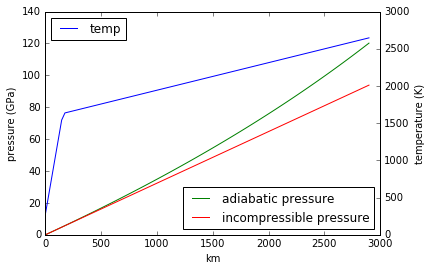

In [17]:
fig, ax1 = plt.subplots()#plt.plot(depths, Temps)
ax1.plot(Depths/1e3, Pressures/1e9, c='g', label='adiabatic pressure' )
ax1.plot(Depths/1e3, lithPressures/1e9, c='r', label='incompressible pressure')

ax1.set_ylabel('pressure (GPa)')
ax1.legend( loc = 4)
ax1.set_xlabel('km')

ax2 = ax1.twinx()
ax2.plot(Depths/1e3, Temps, color='b', label='temp')
ax2.set_ylabel('temperature (K)')

ax2.legend( loc = 2)

plt.show()

### Plot the diffusion and dislocation creep values 
* for a reference strain rate of $10^{-15}$

In [18]:
dp.rTemp

1665.58678

In [19]:
#Check the reference values a point in T-D-strain rate space
#rP = 250e3*10*3300
Ba = 4.3e-12
Rpressure  = (-1./Ba)*(np.log(1.-dp.rho*dp.g*Ba*dp.rDepth)) #lithostatic pressure plus adiabatic factor

Rdf = (1./dp.Adf)*np.exp( ((dp.Edf + dp.Vdf*Rpressure))/((dp.R*dp.rTemp)))

Rds = (1./dp.Ads**(1./dp.n))*(dp.SR**((1.-dp.n)/dp.n))*np.exp( ((dp.Eds + dp.Vds*Rpressure))/((dp.n*dp.R*dp.rTemp)))

Rpr = (1./dp.Apr**(1./dp.np))*(dp.SR**((1.-dp.np)/dp.np))*np.exp( ((dp.Epr + dp.Vpr*Rpressure))/((dp.np*dp.R*dp.rTemp)))


dsfac = Rds/dp.eta0
dffac = Rdf/dp.eta0
prfac = Rpr/dp.eta0

print(Rpressure/1e9, dp.rTemp)
print(Rdf, Rds,Rpr)
print(dsfac, dffac, prfac)
#So our viscosities are effectivily identical at 250 km, and a reference strain rate of 1e-15

(8.2374314849085355, 1665.58678)
(9.2241595362575686e+20, 6.4640608362228312e+20, 5.3205009355610924e+22)
(6.4640608362228313, 9.2241595362575683, 532.05009355610923)


In [20]:
#(10.605395294675773, 9.2241595362575683, 1027.8530283474174)

In [21]:
#Dimensional viscosity at strain rate of 1e-15
T = np.linspace(0,1,50)
df = (1./dp.Adf)*np.exp( ((dp.Edf + dp.Vdf*Pressures))/((dp.R*Temps)))
ds = (1./dp.Ads**(1./dp.n))*(dp.SR**((1.-dp.n)/dp.n))*np.exp( ((dp.Eds + dp.Vds*Pressures))/((dp.n*dp.R*Temps)))
pr = (1./dp.Apr**(1./dp.np))*(dp.SR**((1.-dp.np)/dp.np))*np.exp( ((dp.Epr + dp.Vpr*Pressures))/((dp.np*dp.R*Temps)))
pl = (dp.cohesion + dp.fc*Pressures)/(2.*dp.SR)
nlm = (1./dp.Alm)*np.exp( ((dp.Elm + dp.Vlm*Pressures))/((dp.R*Temps)))


#ndf[np.where( ndf > 1e28 )] = 1e28
#nds[np.where( nds > 1e28 )] = 1e28
#nds[np.where( nds > ndp.up_visc )] = ndp.up_visc

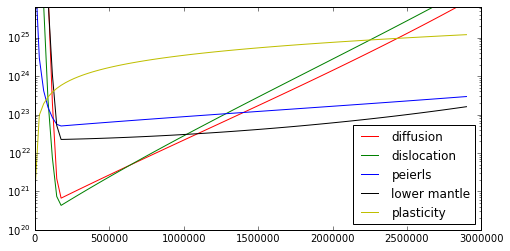

In [22]:
fig, axes = plt.subplots(figsize = (8, 4))
axes.plot(Depths, df, c='r', label = 'diffusion')
axes.plot(Depths, ds, c='g', label = 'dislocation')
axes.plot(Depths, pr, c='b', label = 'peierls')
axes.plot(Depths, nlm, c='k', label = 'lower mantle')
axes.plot(Depths, pl, c='y', label = 'plasticity')

axes.set_ylim([1e20, Rds*1e5])

axes.set_yscale('log')
axes.legend(loc=4)

In [23]:
df.min(), ds.min()

(6.6720746816572346e+20, 4.3230364076883994e+20)

### Scale using a 'reference value' approach

Define a refence point in the model space, similar to Ana-Catalina Plesa, et al., "Thermo-chemical Mantle Convection Simulations using Gaia", a non-dimensional form for the Arhennius law is:

$$\eta(\epsilon, T, p) = A_r \left(\frac{\epsilon}{\epsilon_{ref}}\right)^{\frac{1-n}{n}} \exp \left(\frac{E + pV}{n(T + T_0)} - \frac{E + p_{ref}V}{n(T_{ref} + T_0)} \right) $$

Where $A_r$ is the ratio of the global 'reference visocosity and the viscosity of the relavent flow law at the reference values. 

In [109]:
#Create dimensionless temp and Pressures. 
temps = (Temps - dp.TS)/dp.deltaT 
depths = np.linspace(0.,1.,100)

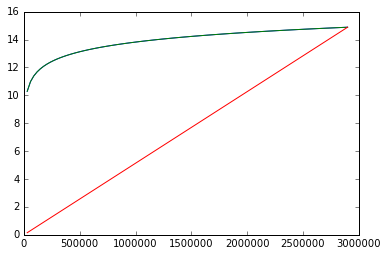

In [110]:
t1 = np.log(Depths[1:])
t2 = (np.log(dp.LS) + np.log(depths[1:]))
t3 = (np.log(dp.LS) * depths[1:])
plt.plot(Depths[1:], t1)
plt.plot(Depths[1:], t2)
plt.plot(Depths[1:], t3)

In [111]:
correctDepths = np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS*depths)/np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS)


#dp.rho*dp.g*dp.Ba*dp.LS

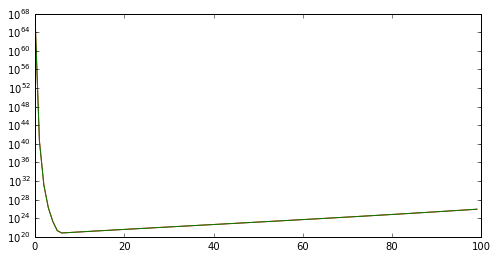

In [112]:
#this is a bit ugly. Due to the fact that the compressible pressure function is a logarithm of dimensional depth, 
#we need to supply a dimensionless depth vector as if it were inside the log function
correctDepths = np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS*depths)/np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS)

dimAct = (dp.Edf + dp.Vdf*Pressures)/(dp.R*Temps)
dimlessAct1 = (ndp.Edf + ndp.Wdf*correctDepths)/(temps + ndp.TSp)
dimlessAct2 = (ndp.Edf + ndp.Wdf*depths)/(temps + ndp.TSp)

fig, axes = plt.subplots(figsize = (8, 4))
axes.plot((1./dp.Adf)*np.exp(dimAct), c= 'r')
axes.plot((1./dp.Adf)*np.exp(dimlessAct1), c= 'g')
#axes.plot(dimlessAct2, c= 'b')
axes.set_yscale('log')
#plt.plot(test, c= 'b')

In [113]:
#ndp.rDepth

In [114]:
#Dimensionless viscosity

ndp.SR = sf.SR*dp.SR #Dimensionless reference strain rate, (sf.SR = dp.L0**2/dp.k )

ndp.rTemp= (dp.rTemp - 273.)/dp.deltaT #Dimensionless reference temp, this should be T'
ndp.rDepth = dp.rDepth/dp.LS #Dimensionless reference depth

correctrDepth = np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS*ndp.rDepth)/np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS)

correctrDepth, ndp.rDepth

(0.068512909009432146, 0.08620689655172414)

In [115]:
ndsp = dsfac*(1.**((1. -dp.n)/dp.n))*np.exp( ((ndp.Eds + (correctDepths*ndp.Wds))/(dp.n*(temps + ndp.TSp))) -
                                     ((ndp.Eds + (correctrDepth*ndp.Wds))/(dp.n*(ndp.rTemp + ndp.TSp))))

ndfp = dffac*np.exp( ((ndp.Edf + (correctDepths*ndp.Wdf))/((temps + ndp.TSp))) - 
              ((ndp.Edf + (correctrDepth*ndp.Wdf))/((ndp.rTemp + ndp.TSp)))  )


ndpr = prfac*(1.**((1. -dp.np)/dp.np))*np.exp( ((ndp.Eps + (correctDepths*ndp.Wps))/(dp.np*(temps + ndp.TSp))) -
                                     ((ndp.Eps + (correctrDepth*ndp.Wps))/(dp.np*(ndp.rTemp + ndp.TSp))))


ndpl = (ndp.cohesion + ndp.fcd*depths)/(2.*ndp.SR)


#Also get Dislocation creep, Peierls creep at varying strain rates


ndsp1 = dsfac*(10.**((1. -dp.n)/dp.n))*np.exp( ((ndp.Eds + (correctDepths*ndp.Wds))/(dp.n*(temps + ndp.TSp))) -
                                     ((ndp.Eds + (correctrDepth*ndp.Wds))/(dp.n*(ndp.rTemp + ndp.TSp))))

ndsp2 = dsfac*(0.1**((1. -dp.n)/dp.n))*np.exp( ((ndp.Eds + (correctDepths*ndp.Wds))/(dp.n*(temps + ndp.TSp))) -
                                     ((ndp.Eds + (correctrDepth*ndp.Wds))/(dp.n*(ndp.rTemp + ndp.TSp))))


ndpr1 = prfac*(10.**((1. -dp.np)/dp.np))*np.exp( ((ndp.Eps + (correctDepths*ndp.Wps))/(dp.np*(temps + ndp.TSp))) -
                                     ((ndp.Eps + (correctrDepth*ndp.Wps))/(dp.np*(ndp.rTemp + ndp.TSp))))

ndpr2 = prfac*(0.1**((1. -dp.np)/dp.np))*np.exp( ((ndp.Eps + (correctDepths*ndp.Wps))/(dp.np*(temps + ndp.TSp))) -
                                     ((ndp.Eps + (correctrDepth*ndp.Wps))/(dp.np*(ndp.rTemp + ndp.TSp))))

ndpl1 = (ndp.cohesion + ndp.fcd*depths)/(2.*10.*ndp.SR)
ndpl2 = (ndp.cohesion + ndp.fcd*depths)/(2.*0.1*ndp.SR)


In [116]:
ndp.SR

8410.0

In [117]:
ndfp.min(), ndsp.min(), dsfac

(6.6720746816572589, 4.3230364076883925, 6.4640608362228313)

(0, 0.9)

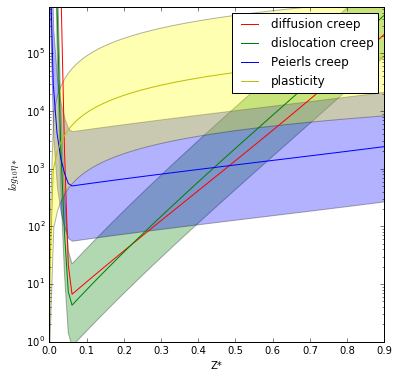

In [118]:
fig, axes = plt.subplots(figsize = (6, 6))

#axes.fill_between(depths, ndsp1,ndsp2,facecolor='green',alpha=0.5)
axes.plot(depths, ndfp, c='r', label='diffusion creep')
axes.plot(depths,ndsp, c='g', label='dislocation creep')
axes.plot(depths,ndpr, c='b', label='Peierls creep')
axes.plot(depths,ndpl, c='y', label='plasticity')


axes.fill_between(depths, ndsp1,ndsp2,facecolor='green',alpha=0.3)

axes.fill_between(depths, ndpr1,ndpr2,facecolor='blue',alpha=0.3)

axes.fill_between(depths, ndpl1,ndpl2,facecolor='yellow',alpha=0.3)


axes.set_ylabel(r'$log_{10} \eta*$')
axes.set_xlabel(r'Z*')

axes.set_ylim(1., 6.4*1e5)

axes.set_yscale('log')
axes.legend(loc=1)
axes.set_xlim([0,0.9])


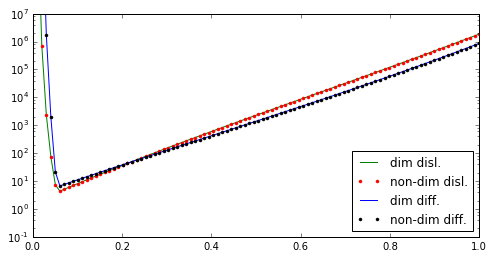

In [120]:
fig, axes = plt.subplots(figsize = (8, 4))
#axes.plot(depths, ds/df, c='g', label='dimensional')
#axes.plot(depths, ndsp/ndfp, c='r', label='dimensionless')

axes.plot(depths, ds/1e20, c='g', label='dim disl.')
axes.plot(depths, ndsp, 'r.', label='non-dim disl.')

axes.plot(depths, df/1e20, 'b', label='dim diff.')
axes.plot(depths, ndfp, 'k.', label='non-dim diff.')

#axes.plot(depths, (Temps - dp.TS)/dp.deltaTa, c='g', label='dimensional')
#axes.plot(depths, temps, c='r', label='dimensionless')
axes.set_ylim(1e-1, 1e7)
axes.set_yscale('log')
axes.legend(loc = 4)
